# DAPA Tutorial #5: DEM

## Load environment variables
Please make sure that the environment variable "DAPA_URL" is set in the `custom.env` file. You can check this by executing the following block. 

If DAPA_URL is not set, please create a text file named `custom.env` in your home directory with the following input: 
>DAPA_URL=YOUR-PERSONAL-DAPA-APP-URL

In [1]:
from edc import setup_environment_variables
setup_environment_variables()

API credentials have automatically been injected for your active subscriptions.  
The following environment variables are now available:

The following additional environment variables have been loaded from `~/custom.env`:
* `AWS_BUCKET`
* `DAPA_URL`
* `DB_HOST`, `DB_NAME`, `DB_PASSWORD`, `DB_USER`
* `OGC_EDC_URL`
* `REFERENCE_DATA`


## Check notebook compabtibility
**Please note:** If you conduct this notebook again at a later time, the base image of this Jupyter Hub service can include newer versions of the libraries installed. Thus, the notebook execution can fail. This compatibility check is only necessary when something is broken. 

In [2]:
from edc import check_compatibility
check_compatibility("user-0.24.5", dependencies=[])

## Load libraries

Python libraries used in this tutorial will be loaded.

In [3]:
import os
import xarray as xr
import pandas as pd
import requests
import matplotlib
import rasterio
from rasterio.plot import show
from ipyleaflet import Map, Rectangle, DrawControl, basemaps, basemap_to_tiles
%matplotlib inline

## Set DAPA endpoint
Execute the following code to check if the DAPA_URL is available in the environment variable and to set the `/dapa` endpoint. 

In [4]:
service_url = None
dapa_url = None

if 'DAPA_URL' not in os.environ:
    print('!! DAPA_URL does not exist as environment variable. Please make sure this is the case - see first block of this notebook! !!')
else:    
    service_url = os.environ['DAPA_URL']
    dapa_url = '{}/{}'.format(service_url, 'oapi')
    print('DAPA path: {}'.format(dapa_url.replace(service_url, '')))

DAPA path: /oapi


## Get collections supported by this endpoint
This request provides a list of collections. The path of each collection is used as starting path of this service.

In [5]:
collections_url = '{}/{}'.format(dapa_url, 'collections')
collections = requests.get(collections_url, headers={'Accept': 'application/json'})

print('DAPA path: {}'.format(collections.url.replace(service_url, '')))
collections.json()

DAPA path: /oapi/collections


['/oapi/collections/DEM/',
 '/oapi/collections/L8L1C/',
 '/oapi/collections/S1GRD/',
 '/oapi/collections/S2L1C/',
 '/oapi/collections/S2L2A/',
 '/oapi/collections/S3OLCI/',
 '/oapi/collections/S3SLSTR/',
 '/oapi/collections/S5PL2/',
 '/oapi/collections/MODIS/']

## Get fields of collection DEM
The fields (or variables in other DAPA endpoints - these are the bands of the raster data) can be retrieved in all requests to the DAPA endpoint. In addition to the fixed set of fields, "virtual" fields can be used to conduct math operations (e.g., the calculation of indices). 

In [6]:
collection = 'DEM'

fields_url = '{}/{}/{}/{}'.format(dapa_url, 'collections', collection, 'dapa/fields')
fields = requests.get(fields_url, headers={'Accept': 'application/json'})

print('DAPA path: {}'.format(fields.url.replace(service_url, '')))
fields.json()

DAPA path: /oapi/collections/DEM/dapa/fields


[{'id': 'DEM', 'wavelength': None}]

## Retrieve a subset of an area of interest

### Set DAPA URL and parameters
The output of this request is a single raster (`area` endpoint). As the input collection (DEM) is a single raster as well, only subsetting is done, no aggregation method needs to be specified.

To retrieve a subset of an area of interest, a bounding box (`bbox`) or polygon geometry (`geom`) needs to be provided. Also the band (`field`) to be returned by DAPA needs to be specified.

In [7]:
# DAPA URL
url = '{}/{}/{}/{}'.format(dapa_url, 'collections', collection, 'dapa/area')

# Parameters for this request
params = {
    'bbox': '11,48,12,48.5',
    'fields': 'DEM'
}

# show area in the map
m = Map(
    basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik),
    center=(48.25, 11.5),
    zoom=9
)

bbox = [float(coord) for coord in params['bbox'].split(',')]
rectangle = Rectangle(bounds=((bbox[1], bbox[0]), (bbox[3], bbox[2])))
m.add_layer(rectangle)
m

Map(center=[48.25, 11.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

### Build request URL and conduct request

In [8]:
params_str = "&".join("%s=%s" % (k, v) for k,v in params.items())
r = requests.get(url, params=params_str)

print('DAPA path: {}'.format(r.url.replace(service_url, '')))
print('Status code: {}'.format(r.status_code))

DAPA path: /oapi/collections/DEM/dapa/area?bbox=11,48,12,48.5&fields=DEM
Status code: 200


### Write raster dataset to GeoTIFF file
The response of the `area` endpoint is currently a GeoTIFF file, which can either be saved to disk or used directly in further processing.

In [9]:
with open('dem_subset.tif', 'wb') as filew:
    filew.write(r.content)

### Open raster dataset with xarray
The GeoTIFF file can be opened with xarray. As the request only specified one field and no aggregation is needed, only one band is available.

In [10]:
ds = xr.open_rasterio('dem_subset.tif')
ds

<xarray.DataArray (band: 1, y: 512, x: 512)>
[262144 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 48.5 48.5 48.5 48.5 48.5 ... 48.0 48.0 48.0 48.0 48.0
  * x        (x) float64 11.0 11.0 11.0 11.01 11.01 ... 11.99 12.0 12.0 12.0
Attributes:
    transform:               (0.001953125, 0.0, 11.0, 0.0, -0.0009765625, 48.5)
    crs:                     +init=epsg:4326
    res:                     (0.001953125, 0.0009765625)
    is_tiled:                0
    nodatavals:              (nan,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    descriptions:            ('DEM',)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

### Plot DEM image

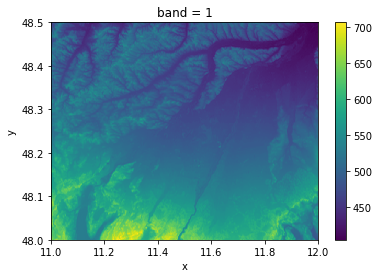

In [11]:
ds[0].plot()

## Output gdalinfo

In [12]:
!gdalinfo -stats dem_subset.tif

Driver: GTiff/GeoTIFF
Files: dem_subset.tif
Size is 512, 512


Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (11.000000000000000,48.500000000000000)
Pixel Size = (0.001953125000000,-0.000976562500000)
Metadata:
  AREA_OR_POINT=Area
  TIFFTAG_RESOLUTIONUNIT=1 (unitless)
  TIFFTAG_XRESOLUTION=1
  TIFFTAG_YRESOLUTION=1
Image Structure Metadata:
  COMPRESSION=DEFLATE
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  11.0000000,  48.5000000) ( 11d 0' 0.00"E, 48d30' 0.00"N)
Lower Left  (  11.0000000,  48.0000000) ( 11d 0' 0.00"E, 48d 

## Retrieve DEM value within an area of interest aggregated spatially
The output of this request is a single value requested from an area of interest (`value/area` endpoint). As the input collection (DEM) is a single raster, only spatial aggregation is conducted.

To retrieve a single value of an area of interest, a bounding box (`bbox`) or polygon geometry (`geom`) needs to be provided together with the `aggregate` parameter, which specifies the aggregation methods being conducted. The band (`field`) to be returned by DAPA needs to be specified.

The response of this request returns plain text with values splitted by comma. The order of the values relates to the order of the functions specified in the `aggregate` parameter. Additional output formats will be integrated within the testbed activtiy. 

In [13]:
url = '{}/{}/{}/{}'.format(dapa_url, 'collections', collection, 'dapa/value/area')
params = {
    'bbox': '11,48,12,48.5',
    'fields': 'DEM',
    'aggregate': 'min,max,avg'
}

params_str = "&".join("%s=%s" % (k, v) for k,v in params.items())
r = requests.get(url, params=params_str)

print('DAPA path: {}'.format(r.url.replace(service_url, '')))
print('Status code: {}'.format(r.status_code))

DAPA path: /oapi/collections/DEM/dapa/value/area?bbox=11,48,12,48.5&fields=DEM&aggregate=min,max,avg
Status code: 200


Print values of the request

In [14]:
values = r.text.split(',')
print('min: %s' % values[0])
print('max: %s' % values[1])
print('avg: %s' % values[2])

min: 404.0
max: 706.0
avg: 515.0584


## Retrieve DEM value at a specific point
The output of this request is a single value requested from a point of interest (`value/position` endpoint). As the input collection (DEM) is a single raster and the requested geometry is a point, no aggregation is needed.

To retrieve a single value of a point, the parameter `point` needs to be provided. The band (`field`) to be returned by DAPA needs to be specified.

The response of this request returns plain text with values splitted by comma. The order of the values relates to the order of the fields specified in the `fields` parameter. Additional output formats will be integrated within the testbed activtiy. 

In [15]:
url = '{}/{}/{}/{}'.format(dapa_url, 'collections', collection, 'dapa/value/position')
params = {
    'point': '11,48',
    'fields': 'DEM'
}

params_str = "&".join("%s=%s" % (k, v) for k,v in params.items())
r = requests.get(url, params=params_str)

print('DAPA path: {}'.format(r.url.replace(service_url, '')))
print('Status code: {}'.format(r.status_code))
print('Value: {}'.format(r.text))

DAPA path: /oapi/collections/DEM/dapa/value/position?point=11,48&fields=DEM
Status code: 200
Value: 648.0


## Retrieve DEM value at a specific point calculated in feet
You can do math operations in the `fields` parameter. To calculate from meter to feet you need only to specify a virtual field: 
> FEET=DEM/0.3048

In [16]:
url = '{}/{}/{}/{}'.format(dapa_url, 'collections', collection, 'dapa/value/position')
params = {
    'point': '11,48',
    'fields': 'FEET=DEM/0.3048'
}

params_str = "&".join("%s=%s" % (k, v) for k,v in params.items())
r = requests.get(url, params=params_str)

print('DAPA path: {}'.format(r.url.replace(service_url, '')))
print('Status code: {}'.format(r.status_code))
print('Value: {}'.format(r.text))

DAPA path: /oapi/collections/DEM/dapa/value/position?point=11,48&fields=FEET=DEM/0.3048
Status code: 200
Value: 2125.9841
